In [905]:
import pandas as pd
import pickle
import numpy as np
import seaborn as sns

from sklearn.cross_validation import KFold
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn import preprocessing
import statsmodels.formula.api as smf

import diagnostic_plots
import matplotlib.pyplot as plt
%matplotlib inline

## Get house data

In [906]:
def flatten(nested_list):
    return [k for sub_list in nested_list for k in sub_list]


with open("county_entries_dict.pickle", "rb") as f:
    county_entries_dict = pickle.load(f)
    
df = pd.DataFrame(flatten(county_entries_dict.values()), columns=["zipcode",
                                                                  "price", 
                                                                  "hometype", 
                                                                  "sqft",
                                                                  "bedrooms",
                                                                  "bathrooms",
                                                                  "livingarea",
                                                                  "lotsize",
                                                                  "latitude",
                                                                  "longitude",
                                                                  "daysonzillow",
                                                                  "yearbuilt"]) 

### Basic modifications ###

In [907]:
#  Make copy so I can keep track of difference
df2 = df.copy()


#  This is for handling beds/baths which don't make sense (nulls)
df2.dropna(inplace=True)

#  This is for handling entries which don't have build year
df2.drop(df2[df2.yearbuilt == -1].index, inplace=True)


#  For readability
df2.hometype = pd.Series([k.lower() for k in df2.hometype])


#  Lot isn't a helpful home type to look at
df2.drop(df2[(df2.hometype == "LOT") | (df2.hometype == "HOME_TYPE_UNKNOWN")].index, inplace=True)

#  Make categorical data qualitative
cat_hometype = pd.get_dummies(df2.hometype)
df2 = pd.concat([df2, cat_hometype], axis=1)
df2.drop(["hometype"], axis=1, inplace=True)

#  Easier to understand
df2['ageyears'] = (2018-df2.yearbuilt)

#  Model does best with house price capping at $10MM
df2 = df2[df2.price <= 10000000]

#  Closer to a normal distribution
df2['logprice'] = np.log(df2.price)

#  Outliers & high leverage points
df2.drop(df2.index[[1516, 4701, 1055, 2281, 308, 833, 5028]], inplace=True)

### Distributions ###

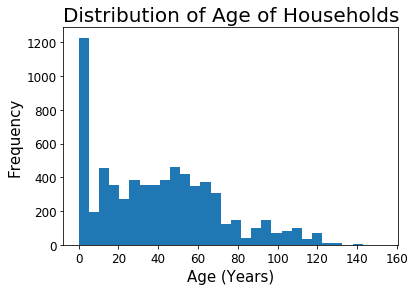

In [908]:
plt.hist(df2.ageyears, bins=30)
plt.title("Distribution of Age of Households", fontsize=20)
plt.xlabel("Age (Years)", fontsize=15)
plt.ylabel("Frequency", fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=12);

plt.savefig('agedist.png', dpi = 300)

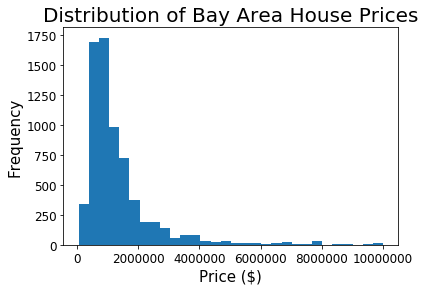

In [909]:
plt.hist(df2.price, bins=30)
plt.title("Distribution of Bay Area House Prices", fontsize=20)
plt.xlabel("Price ($)", fontsize=15)
plt.ylabel("Frequency", fontsize=15)
plt.ticklabel_format(style = 'plain')
plt.tick_params(axis='both', which='major', labelsize=12);

plt.savefig('pricedist.png', dpi = 300)

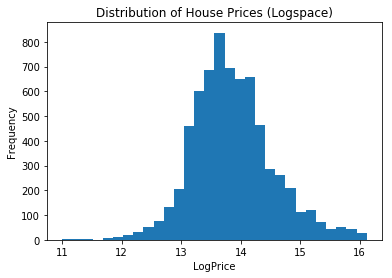

In [910]:
plt.hist(df2.logprice, bins=30)
plt.title("Distribution of House Prices (Logspace)")
plt.xlabel("LogPrice")
plt.ylabel("Frequency");

/Users/tarekbarnes/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


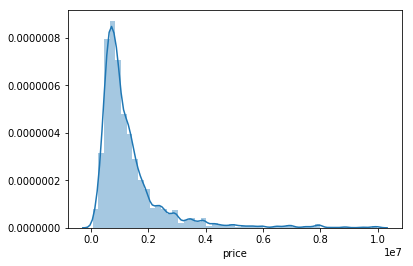

In [911]:
sns.distplot(df2.price);

## Define indep & dep variables ##

In [912]:
y = df2.price
x = df2.drop(['price', 'logprice'], axis=1)
x_train, x_test, y_train, y_test = train_test_split(x,y)

## Normalization

In [913]:
std_scaler = preprocessing.StandardScaler()
x_train_norm = std_scaler.fit_transform(x_train)
x_train_norm = pd.DataFrame(x_train_norm, columns=x_train.columns)

x_test_norm = std_scaler.transform(x_test)
y_train2 = y_train.reset_index()
y_train2['logprice'] = np.log(y_train2.price)

## Regularization

In [914]:
from sklearn.linear_model import LassoCV
from sklearn.model_selection import GridSearchCV

lasso = Lasso()
#  (I already normalized)
# ssX = StandardScaler()
# x_train_scaled = ssX.fit_transform(X_train_full)

initial_alphas = [1e-10, 1e-8, 1e-6, 1e-4, 1e-2, 1e-1, 0, 1, 10, 100]
secondary_alphas = np.linspace(2000, 5000, 1000)

params = {
    'alpha': secondary_alphas,
    'max_iter': [1000, 2000, 4000]
}

grid = GridSearchCV(lasso, param_grid=params, cv=8)
grid.fit(x_train_norm, y_train2)

GridSearchCV(cv=8, error_score='raise',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': array([2000.   , 2003.003, ..., 4996.997, 5000.   ]), 'max_iter': [1000, 2000, 4000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [915]:
grid.best_score_

0.6484732701637186

In [916]:
grid.best_params_

{'alpha': 4108.108108108108, 'max_iter': 1000}

In [917]:
grid.grid_scores_

/Users/tarekbarnes/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.64446, std: 0.05319, params: {'alpha': 2000.0, 'max_iter': 1000},
 mean: 0.64446, std: 0.05319, params: {'alpha': 2000.0, 'max_iter': 2000},
 mean: 0.64446, std: 0.05319, params: {'alpha': 2000.0, 'max_iter': 4000},
 mean: 0.64447, std: 0.05318, params: {'alpha': 2003.003003003003, 'max_iter': 1000},
 mean: 0.64447, std: 0.05318, params: {'alpha': 2003.003003003003, 'max_iter': 2000},
 mean: 0.64447, std: 0.05318, params: {'alpha': 2003.003003003003, 'max_iter': 4000},
 mean: 0.64449, std: 0.05317, params: {'alpha': 2006.006006006006, 'max_iter': 1000},
 mean: 0.64449, std: 0.05317, params: {'alpha': 2006.006006006006, 'max_iter': 2000},
 mean: 0.64449, std: 0.05317, params: {'alpha': 2006.006006006006, 'max_iter': 4000},
 mean: 0.64450, std: 0.05316, params: {'alpha': 2009.009009009009, 'max_iter': 1000},
 mean: 0.64450, std: 0.05316, params: {'alpha': 2009.009009009009, 'max_iter': 2000},
 mean: 0.64450, std: 0.05316, params: {'alpha': 2009.009009009009, 'max_iter': 4000},
 

In [918]:
lr.intercept_

1354296.3202354223

### How does regularization compare to optimal OLS?

In [919]:
lr = LinearRegression()
lr.fit(x_train_norm, np.exp(y_train2.logprice))
lr.score(x_test_norm, y_test)

0.5815155214955195

In [920]:
lr.coef_

array([-1.24692669e+05, -1.52566480e+17, -1.13036000e+05,  1.63766250e+05,
        1.52566480e+17,  6.62100000e+03, -3.85072000e+05, -4.23280000e+05,
        6.53170000e+04,  7.76301084e+18, -4.66700000e+03, -8.29120000e+04,
       -8.34450000e+03, -3.22012500e+03, -1.24720000e+04, -2.70420000e+04,
       -1.12080000e+05, -5.46420000e+04,  7.76301084e+18])

### Calculating RMSE

In [921]:
from sklearn.metrics import mean_squared_error, r2_score

In [922]:
y_pred = lr.predict(x_test_norm)
y_pred

array([ 930243.65824543, 1798083.65824543, 1156035.65824543, ...,
       1229763.65824543,  614851.65824543, 2257859.65824543])

In [923]:
y_pred.max()

8640451.658245428

In [924]:
y_pred[:10], y_test[:10]

(array([ 930243.65824543, 1798083.65824543, 1156035.65824543,
        1126851.65824543,  902083.65824543, 1912771.65824543,
        1545155.65824543,  606147.65824543,  532419.65824543,
        1320899.65824543]), 6951    1179000.0
 535      979900.0
 4687     995000.0
 3108     599900.0
 6928     898888.0
 1027    1369301.0
 1883    1424999.0
 2714     490000.0
 2785    1085000.0
 2161     735000.0
 Name: price, dtype: float64)

In [925]:
#  RMSE, manual
np.sqrt(((y_pred - y_test)**2).mean())

805685.526070051

In [926]:
#  RMSE, easy way (sanity check)
np.sqrt(mean_squared_error(y_test, y_pred))

805685.5260700512

In [927]:
#  Worst case
np.abs(y_pred - y_test).max()

7700451.6582454275

In [928]:
#  Debugging: this should be the same as optimal linear regression r^2
r2_score(y_test, y_pred)

0.5815155214955195

## Exploration

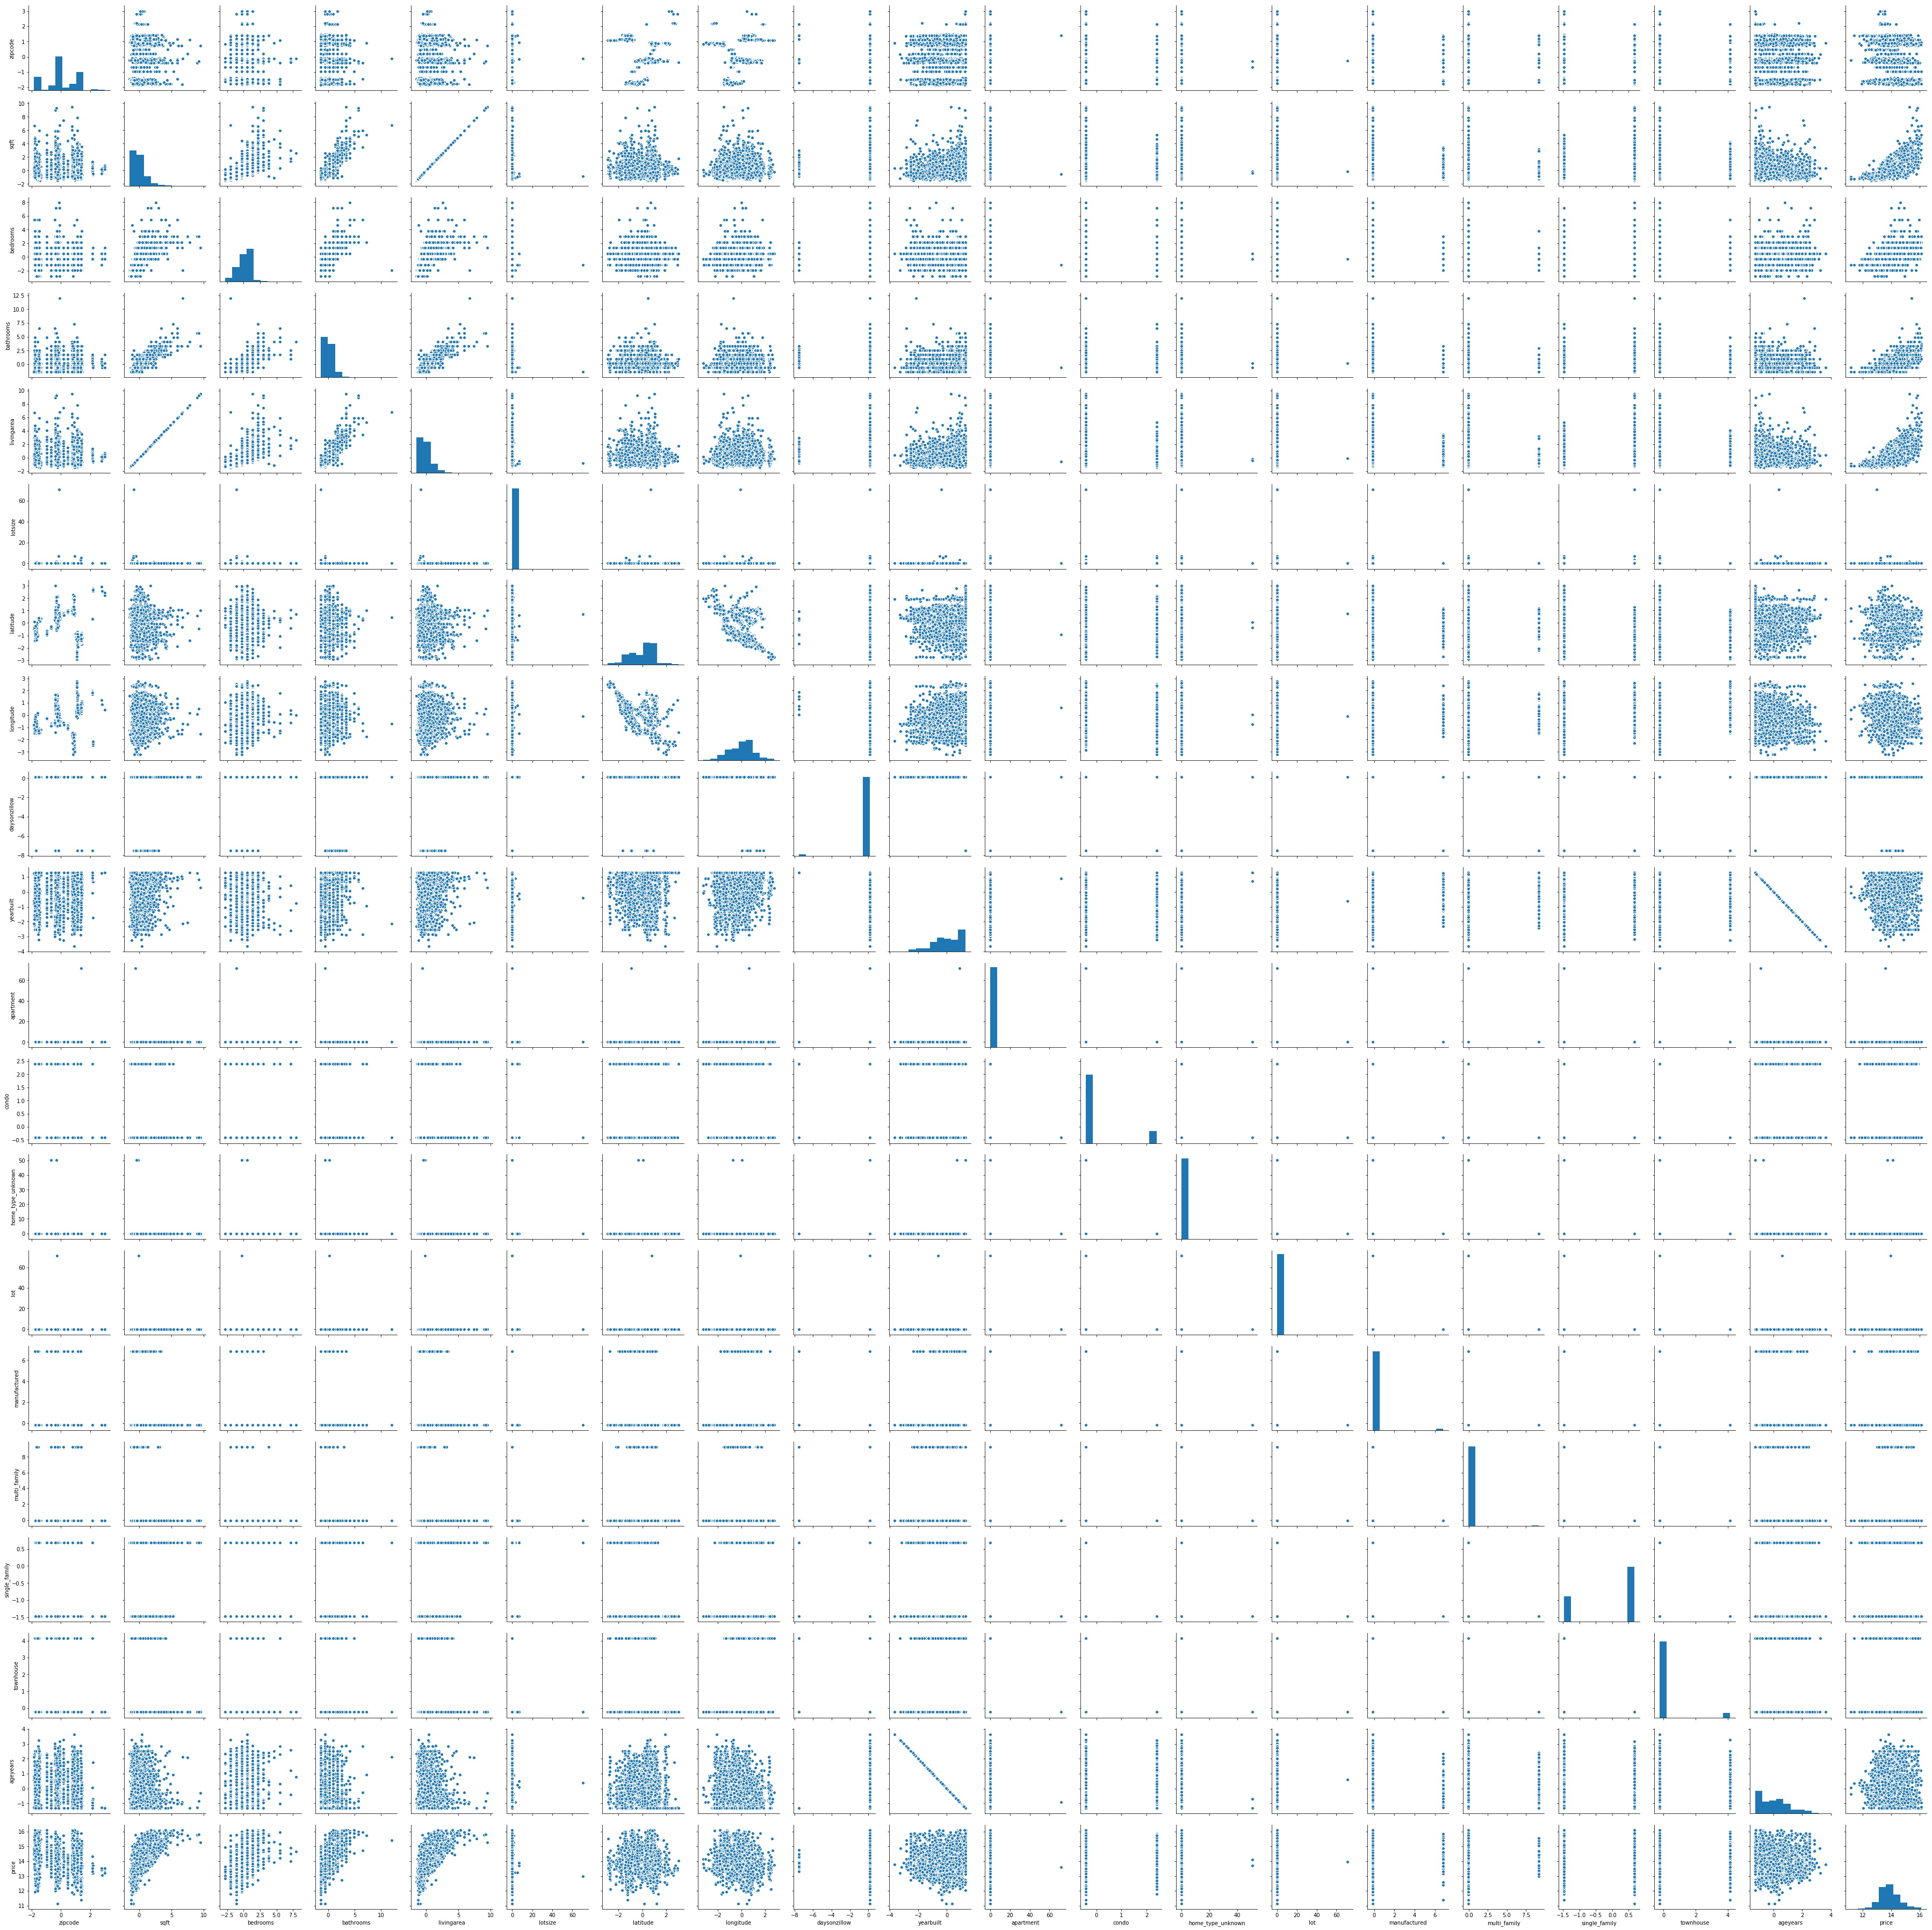

In [929]:
training_data = pd.concat([x_train_norm, np.log(y_train2.price)], axis=1)
sns.pairplot(training_data)

In [930]:
# set(training_data.sqft)

In [931]:
# for diagnostics and sanity checking

for col in training_data.columns:
    print("{}:".format(col))
    print(set(training_data[col]))
    print("\n \n")

zipcode:
{0.748179118608443, 1.397847991281618, 1.3920987092225634, 1.176500632008014, 2.1567532230768314, 1.3949733502520907, 1.4380929656950006, -0.3556830367300492, 1.4035972733406727, -0.25219595966706554, 1.354728375838708, 3.007646967816919, -1.4854169613342874, 1.423719760547364, 1.3662269399568174, 2.2084967616083233, 0.4664642977147653, -0.34705911364146724, 0.8775379649371725, -1.7728810642870196, -1.7153882436964731, -1.5429097819248336, -0.0854667799544808, 0.9551532727344102, -0.9679815760193691, -1.5055394485409785, 0.8401676315533173, 3.0105216088464464, 0.8861618880257545, 0.828669067435208, 1.3834747861339813, -1.7355107309031643, -0.17458065186982782, -0.6833921140961641, -0.09983998510211742, 0.1991226819687242, 0.18474947682108758, 0.4693389387442926, 1.0385178625907026, -0.14295960054502727, -0.21482562628321034, -1.6406475769287627, -1.5256619357476697, -0.2866916520213934, -1.7556332181098557, -0.9708562170488964, 1.4208451195178367, -1.4882916023638146, -1.54578

# Models

In [932]:
#  model 0
lm0 = smf.ols('price ~ sqft', data=pd.concat([x_train_norm, y_train2], axis=1))
fit0 = lm0.fit()
fit0.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.484
Model:                            OLS   Adj. R-squared:                  0.484
Method:                 Least Squares   F-statistic:                     4805.
Date:                Fri, 20 Jul 2018   Prob (F-statistic):               0.00
Time:                        13:15:17   Log-Likelihood:                -77308.
No. Observations:                5117   AIC:                         1.546e+05
Df Residuals:                    5115   BIC:                         1.546e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -4.322e+04   2.37e+04     -1.826      0.068   -8.96e+04    3174.192
sqft         647.4606      9.341     69.316      0.000     629.149     665.772
==============================================================================
Omnibus:                     2695.791   Durbin-Watson:                   2.015
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            30748.668
Skew:                           2.268   Prob(JB):                         0.00
Kurtosis:                      14.119   Cond. No.                     4.86e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.86e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [933]:
#  model 1
lm1 = smf.ols('price ~ sqft + bedrooms + bathrooms + ageyears', data=pd.concat([x_train_norm, y_train2], axis=1))
fit1 = lm1.fit()
fit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.530
Model:                            OLS   Adj. R-squared:                  0.530
Method:                 Least Squares   F-statistic:                     1443.
Date:                Fri, 20 Jul 2018   Prob (F-statistic):               0.00
Time:                        13:15:17   Log-Likelihood:                -77069.
No. Observations:                5117   AIC:                         1.541e+05
Df Residuals:                    5112   BIC:                         1.542e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -2.474e+05   4.16e+04     -5.948      0.000   -3.29e+05   -1.66e+05
sqft         639.2980     17.356     36.835      0.000     605.274     673.322
bedrooms   -2.009e+05   1.41e+04    -14.229      0.000   -2.29e+05   -1.73e+05
bathrooms   2.133e+05   1.86e+04     11.463      0.000    1.77e+05     2.5e+05
ageyears    7869.6569    407.631     19.306      0.000    7070.525    8668.788
==============================================================================
Omnibus:                     2696.791   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            37824.959
Skew:                           2.193   Prob(JB):                         0.00
Kurtosis:                      15.577   Cond. No.                     9.19e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.19e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [934]:
#  model 2
lm2 = smf.ols('price ~ sqft + (bedrooms + bathrooms)**2 + bedrooms:bathrooms + bedrooms + bathrooms + ageyears', data=pd.concat([x_train_norm, y_train2], axis=1))
fit2 = lm2.fit()
fit2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.533
Model:                            OLS   Adj. R-squared:                  0.532
Method:                 Least Squares   F-statistic:                     1166.
Date:                Fri, 20 Jul 2018   Prob (F-statistic):               0.00
Time:                        13:15:18   Log-Likelihood:                -77056.
No. Observations:                5117   AIC:                         1.541e+05
Df Residuals:                    5111   BIC:                         1.542e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           2.427e+04   6.66e+04      0.364      0.716   -1.06e+05    1.55e+05
sqft                 623.4260     17.577     35.468      0.000     588.967     657.885
bedrooms            -2.68e+05   1.91e+04    -14.044      0.000   -3.05e+05   -2.31e+05
bathrooms           1.166e+05   2.63e+04      4.440      0.000    6.51e+04    1.68e+05
bedrooms:bathrooms  2.556e+04   4904.788      5.212      0.000    1.59e+04    3.52e+04
ageyears            7641.2393    408.947     18.685      0.000    6839.527    8442.951
==============================================================================
Omnibus:                     2709.136   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            37274.867
Skew:                           2.213   Prob(JB):                         0.00
Kurtosis:                      15.459   Cond. No.                     1.53e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.53e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [935]:
#  model 3
lm3 = smf.ols('price ~ sqft + (bedrooms + bathrooms)**3 + bedrooms:bathrooms + bedrooms + bathrooms + ageyears', data=pd.concat([x_train_norm, y_train2], axis=1))
fit3 = lm3.fit()
fit3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.533
Model:                            OLS   Adj. R-squared:                  0.532
Method:                 Least Squares   F-statistic:                     1166.
Date:                Fri, 20 Jul 2018   Prob (F-statistic):               0.00
Time:                        13:15:18   Log-Likelihood:                -77056.
No. Observations:                5117   AIC:                         1.541e+05
Df Residuals:                    5111   BIC:                         1.542e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           2.427e+04   6.66e+04      0.364      0.716   -1.06e+05    1.55e+05
sqft                 623.4260     17.577     35.468      0.000     588.967     657.885
bedrooms            -2.68e+05   1.91e+04    -14.044      0.000   -3.05e+05   -2.31e+05
bathrooms           1.166e+05   2.63e+04      4.440      0.000    6.51e+04    1.68e+05
bedrooms:bathrooms  2.556e+04   4904.788      5.212      0.000    1.59e+04    3.52e+04
ageyears            7641.2393    408.947     18.685      0.000    6839.527    8442.951
==============================================================================
Omnibus:                     2709.136   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            37274.867
Skew:                           2.213   Prob(JB):                         0.00
Kurtosis:                      15.459   Cond. No.                     1.53e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.53e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [936]:
#  model 4
lm4 = smf.ols('price ~ sqft + bedrooms + bathrooms + ageyears + apartment + condo + manufactured + multi_family + single_family + townhouse', data=pd.concat([x_train_norm, y_train2], axis=1))
fit4 = lm4.fit()
fit4.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.536
Model:                            OLS   Adj. R-squared:                  0.535
Method:                 Least Squares   F-statistic:                     589.1
Date:                Fri, 20 Jul 2018   Prob (F-statistic):               0.00
Time:                        13:15:18   Log-Likelihood:                -77040.
No. Observations:                5117   AIC:                         1.541e+05
Df Residuals:                    5106   BIC:                         1.542e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -7299.1780   5.74e+04     -0.127      0.899    -1.2e+05    1.05e+05
sqft            642.9231     17.286     37.193      0.000     609.035     676.812
bedrooms      -2.022e+05   1.41e+04    -14.374      0.000    -2.3e+05   -1.75e+05
bathrooms      2.108e+05   1.85e+04     11.384      0.000    1.75e+05    2.47e+05
ageyears       8038.6291    407.611     19.721      0.000    7239.536    8837.722
apartment     -2.217e+05   8.38e+05     -0.264      0.791   -1.87e+06    1.42e+06
condo         -1.988e+05   5.19e+04     -3.829      0.000   -3.01e+05    -9.7e+04
manufactured   4.352e+04   9.13e+04      0.477      0.634   -1.35e+05    2.22e+05
multi_family   -2.76e+05   1.17e+05     -2.362      0.018   -5.05e+05   -4.69e+04
single_family -2.881e+05   4.43e+04     -6.501      0.000   -3.75e+05   -2.01e+05
townhouse     -2.576e+05   6.52e+04     -3.953      0.000   -3.85e+05    -1.3e+05
==============================================================================
Omnibus:                     2683.325   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            37826.317
Skew:                           2.176   Prob(JB):                         0.00
Kurtosis:                      15.588   Cond. No.                     1.81e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.81e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [937]:
#  model 5 - BEST MANUALLY IDENTIFIED

lm5 = smf.ols('price ~ sqft + sqft:bathrooms + bedrooms + bathrooms + ageyears', data=pd.concat([x_train_norm, y_train2.price], axis=1))
fit5 = lm5.fit()
fit5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.530
Model:                            OLS   Adj. R-squared:                  0.530
Method:                 Least Squares   F-statistic:                     1154.
Date:                Fri, 20 Jul 2018   Prob (F-statistic):               0.00
Time:                        13:15:18   Log-Likelihood:                -77069.
No. Observations:                5117   AIC:                         1.542e+05
Df Residuals:                    5111   BIC:                         1.542e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       1.359e+06   1.29e+04    105.457      0.000    1.33e+06    1.38e+06
sqft            8.489e+05    2.6e+04     32.675      0.000    7.98e+05       9e+05
sqft:bathrooms -2778.3739   6234.878     -0.446      0.656    -1.5e+04    9444.656
bedrooms       -2.463e+05   1.85e+04    -13.314      0.000   -2.83e+05    -2.1e+05
bathrooms       2.743e+05   2.43e+04     11.307      0.000    2.27e+05    3.22e+05
ageyears         2.45e+05    1.3e+04     18.865      0.000     2.2e+05     2.7e+05
==============================================================================
Omnibus:                     2697.307   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            37386.542
Skew:                           2.198   Prob(JB):                         0.00
Kurtosis:                      15.491   Cond. No.                         7.92
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [938]:
#  model 6

lm6 = smf.ols('price ~ sqft + sqft:bathrooms + bedrooms + bathrooms + ageyears + apartment + condo + manufactured + multi_family + single_family + townhouse + daysonzillow', data=pd.concat([x_train_norm, y_train2.price], axis=1))
fit6 = lm6.fit()
fit6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.540
Model:                            OLS   Adj. R-squared:                  0.539
Method:                 Least Squares   F-statistic:                     498.9
Date:                Fri, 20 Jul 2018   Prob (F-statistic):               0.00
Time:                        13:15:18   Log-Likelihood:                -77017.
No. Observations:                5117   AIC:                         1.541e+05
Df Residuals:                    5104   BIC:                         1.541e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       1.359e+06   1.28e+04    106.420      0.000    1.33e+06    1.38e+06
sqft             8.53e+05   2.58e+04     33.099      0.000    8.02e+05    9.04e+05
sqft:bathrooms -2562.9286   6184.718     -0.414      0.679   -1.47e+04    9561.771
bedrooms       -2.504e+05   1.84e+04    -13.626      0.000   -2.86e+05   -2.14e+05
bathrooms       2.861e+05   2.42e+04     11.845      0.000    2.39e+05    3.33e+05
ageyears        2.406e+05    1.3e+04     18.504      0.000    2.15e+05    2.66e+05
apartment      -3248.5111   1.17e+04     -0.278      0.781   -2.61e+04    1.96e+04
condo          -7.306e+04   1.84e+04     -3.968      0.000   -1.09e+05    -3.7e+04
manufactured    5853.0253    1.3e+04      0.450      0.653   -1.97e+04    3.14e+04
multi_family   -2.906e+04   1.24e+04     -2.339      0.019   -5.34e+04   -4705.792
single_family  -1.312e+05   2.05e+04     -6.398      0.000   -1.71e+05    -9.1e+04
townhouse      -6.003e+04   1.48e+04     -4.054      0.000   -8.91e+04    -3.1e+04
daysonzillow    8.098e+04    1.2e+04      6.747      0.000    5.75e+04    1.05e+05
==============================================================================
Omnibus:                     2646.336   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            37370.493
Skew:                           2.135   Prob(JB):                         0.00
Kurtosis:                      15.532   Cond. No.                         7.97
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [939]:
#  model 7

lm7 = smf.ols('price ~ sqft + sqft:bathrooms + bedrooms + bathrooms + ageyears + apartment + condo + manufactured + multi_family + single_family + townhouse + daysonzillow + ageyears:daysonzillow + (ageyears ** 2) + (daysonzillow ** 2)', data=pd.concat([x_train_norm, y_train2.price], axis=1))
fit7 = lm7.fit()
fit7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.541
Model:                            OLS   Adj. R-squared:                  0.540
Method:                 Least Squares   F-statistic:                     463.1
Date:                Fri, 20 Jul 2018   Prob (F-statistic):               0.00
Time:                        13:15:18   Log-Likelihood:                -77009.
No. Observations:                5117   AIC:                         1.540e+05
Df Residuals:                    5103   BIC:                         1.541e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept              -1.58e+10   3.98e+09     -3.967      0.000   -2.36e+10   -7.99e+09
sqft                   8.403e+05   2.59e+04     32.401      0.000    7.89e+05    8.91e+05
sqft:bathrooms        -1839.2689   6178.499     -0.298      0.766    -1.4e+04    1.03e+04
bedrooms              -2.471e+05   1.84e+04    -13.456      0.000   -2.83e+05   -2.11e+05
bathrooms              2.885e+05   2.41e+04     11.956      0.000    2.41e+05    3.36e+05
ageyears              -1.222e+10   3.08e+09     -3.967      0.000   -1.83e+10   -6.18e+09
apartment             -3351.2938   1.17e+04     -0.288      0.774   -2.62e+04    1.95e+04
condo                 -7.245e+04   1.84e+04     -3.940      0.000   -1.08e+05   -3.64e+04
manufactured           5033.5941    1.3e+04      0.387      0.698   -2.04e+04    3.05e+04
multi_family          -3.062e+04   1.24e+04     -2.467      0.014    -5.5e+04   -6286.285
single_family         -1.287e+05   2.05e+04     -6.281      0.000   -1.69e+05   -8.85e+04
townhouse             -5.849e+04   1.48e+04     -3.955      0.000   -8.75e+04   -2.95e+04
daysonzillow           1.188e+11   2.99e+10      3.967      0.000    6.01e+10    1.77e+11
ageyears:daysonzillow  9.184e+10   2.31e+10      3.967      0.000    4.65e+10    1.37e+11
==============================================================================
Omnibus:                     2620.539   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            36913.096
Skew:                           2.108   Prob(JB):                         0.00
Kurtosis:                      15.464   Cond. No.                     9.92e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.92e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [940]:
#  model 8

lm8 = smf.ols('price ~ sqft + sqft:bathrooms + bedrooms + bathrooms + ageyears + apartment + condo + manufactured + multi_family + single_family + townhouse + daysonzillow + ageyears:daysonzillow + (ageyears ** 3) + (daysonzillow ** 3)', data=pd.concat([x_train_norm, y_train2.price], axis=1))
fit8 = lm8.fit()
fit8.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.541
Model:                            OLS   Adj. R-squared:                  0.540
Method:                 Least Squares   F-statistic:                     463.1
Date:                Fri, 20 Jul 2018   Prob (F-statistic):               0.00
Time:                        13:15:18   Log-Likelihood:                -77009.
No. Observations:                5117   AIC:                         1.540e+05
Df Residuals:                    5103   BIC:                         1.541e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept              -1.58e+10   3.98e+09     -3.967      0.000   -2.36e+10   -7.99e+09
sqft                   8.403e+05   2.59e+04     32.401      0.000    7.89e+05    8.91e+05
sqft:bathrooms        -1839.2689   6178.499     -0.298      0.766    -1.4e+04    1.03e+04
bedrooms              -2.471e+05   1.84e+04    -13.456      0.000   -2.83e+05   -2.11e+05
bathrooms              2.885e+05   2.41e+04     11.956      0.000    2.41e+05    3.36e+05
ageyears              -1.222e+10   3.08e+09     -3.967      0.000   -1.83e+10   -6.18e+09
apartment             -3351.2938   1.17e+04     -0.288      0.774   -2.62e+04    1.95e+04
condo                 -7.245e+04   1.84e+04     -3.940      0.000   -1.08e+05   -3.64e+04
manufactured           5033.5941    1.3e+04      0.387      0.698   -2.04e+04    3.05e+04
multi_family          -3.062e+04   1.24e+04     -2.467      0.014    -5.5e+04   -6286.285
single_family         -1.287e+05   2.05e+04     -6.281      0.000   -1.69e+05   -8.85e+04
townhouse             -5.849e+04   1.48e+04     -3.955      0.000   -8.75e+04   -2.95e+04
daysonzillow           1.188e+11   2.99e+10      3.967      0.000    6.01e+10    1.77e+11
ageyears:daysonzillow  9.184e+10   2.31e+10      3.967      0.000    4.65e+10    1.37e+11
==============================================================================
Omnibus:                     2620.539   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            36913.096
Skew:                           2.108   Prob(JB):                         0.00
Kurtosis:                      15.464   Cond. No.                     9.92e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.92e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [941]:
#  model 9

lm9 = smf.ols('price ~ sqft + (sqft **2) + (sqft ** 3) + sqft:bathrooms + bedrooms:bathrooms + bedrooms + bathrooms + ageyears + apartment + condo + manufactured + multi_family + single_family + townhouse + daysonzillow + ageyears:daysonzillow + (ageyears ** 3) + (daysonzillow ** 3)', data=pd.concat([x_train_norm, y_train2.price], axis=1))
fit9 = lm9.fit()
fit9.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.545
Model:                            OLS   Adj. R-squared:                  0.544
Method:                 Least Squares   F-statistic:                     436.8
Date:                Fri, 20 Jul 2018   Prob (F-statistic):               0.00
Time:                        13:15:18   Log-Likelihood:                -76987.
No. Observations:                5117   AIC:                         1.540e+05
Df Residuals:                    5102   BIC:                         1.541e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept             -1.508e+10   3.97e+09     -3.801      0.000   -2.29e+10    -7.3e+09
sqft                   8.567e+05   2.59e+04     33.024      0.000    8.06e+05    9.08e+05
sqft:bathrooms        -2.524e+04   7087.186     -3.561      0.000   -3.91e+04   -1.13e+04
bedrooms:bathrooms     5.736e+04   8624.173      6.652      0.000    4.05e+04    7.43e+04
bedrooms              -2.696e+05   1.86e+04    -14.495      0.000   -3.06e+05   -2.33e+05
bathrooms              2.876e+05    2.4e+04     11.970      0.000    2.41e+05    3.35e+05
ageyears              -1.166e+10   3.07e+09     -3.801      0.000   -1.77e+10   -5.65e+09
apartment             -3840.2137   1.16e+04     -0.331      0.741   -2.66e+04    1.89e+04
condo                 -7.834e+04   1.83e+04     -4.274      0.000   -1.14e+05   -4.24e+04
manufactured           3962.8223   1.29e+04      0.306      0.759   -2.14e+04    2.93e+04
multi_family          -3.212e+04   1.24e+04     -2.598      0.009   -5.64e+04   -7882.107
single_family         -1.329e+05   2.04e+04     -6.512      0.000   -1.73e+05   -9.29e+04
townhouse             -6.076e+04   1.47e+04     -4.125      0.000   -8.96e+04   -3.19e+04
daysonzillow           1.133e+11   2.98e+10      3.801      0.000    5.49e+10    1.72e+11
ageyears:daysonzillow  8.765e+10   2.31e+10      3.801      0.000    4.24e+10    1.33e+11
==============================================================================
Omnibus:                     2625.595   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            34167.882
Skew:                           2.142   Prob(JB):                         0.00
Kurtosis:                      14.913   Cond. No.                     1.09e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.09e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [942]:
#  model 10

lm10 = smf.ols('price ~ sqft + (sqft **2) + (sqft ** 3) + sqft:bathrooms + bedrooms:bathrooms + bedrooms + bathrooms + ageyears + apartment + condo + manufactured + multi_family + single_family + townhouse + daysonzillow + ageyears:daysonzillow + manufactured:multi_family + manufactured:single_family + manufactured:townhouse + manufactured:condo + condo:single_family + condo:multi_family + condo:townhouse + single_family:multi_family + townhouse:multi_family + (ageyears ** 3) + (daysonzillow ** 3)', data=pd.concat([x_train_norm, y_train2.price], axis=1))
fit10 = lm10.fit()
fit10.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.545
Model:                            OLS   Adj. R-squared:                  0.544
Method:                 Least Squares   F-statistic:                     436.8
Date:                Fri, 20 Jul 2018   Prob (F-statistic):               0.00
Time:                        13:15:18   Log-Likelihood:                -76987.
No. Observations:                5117   AIC:                         1.540e+05
Df Residuals:                    5102   BIC:                         1.541e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                  -1.328e+10   3.49e+09     -3.801      0.000   -2.01e+10   -6.43e+09
sqft                        8.567e+05   2.59e+04     33.024      0.000    8.06e+05    9.08e+05
sqft:bathrooms             -2.524e+04   7087.186     -3.561      0.000   -3.91e+04   -1.13e+04
bedrooms:bathrooms          5.736e+04   8624.173      6.652      0.000    4.05e+04    7.43e+04
bedrooms                   -2.696e+05   1.86e+04    -14.495      0.000   -3.06e+05   -2.33e+05
bathrooms                   2.876e+05    2.4e+04     11.970      0.000    2.41e+05    3.35e+05
ageyears                   -1.166e+10   3.07e+09     -3.801      0.000   -1.77e+10   -5.65e+09
apartment                  -3840.2136   1.16e+04     -0.331      0.741   -2.66e+04    1.89e+04
condo                       3.584e+09   9.43e+08      3.801      0.000    1.74e+09    5.43e+09
manufactured                1.227e+09   3.23e+08      3.801      0.000    5.94e+08    1.86e+09
multi_family                9.055e+08   2.38e+08      3.801      0.000    4.38e+08    1.37e+09
single_family               1.203e+09   3.16e+08      3.800      0.000    5.82e+08    1.82e+09
townhouse                    1.97e+08   5.19e+07      3.800      0.000    9.54e+07    2.99e+08
daysonzillow                1.133e+11   2.98e+10      3.801      0.000    5.49e+10    1.72e+11
ageyears:daysonzillow       8.765e+10   2.31e+10      3.801      0.000    4.24e+10    1.33e+11
manufactured:multi_family  -5.521e+07   1.45e+07     -3.801      0.000   -8.37e+07   -2.67e+07
manufactured:single_family  8.767e+08   2.31e+08      3.801      0.000    4.24e+08    1.33e+09
manufactured:townhouse      1.437e+08   3.78e+07      3.801      0.000    6.96e+07    2.18e+08
manufactured:condo         -2.251e+08   5.92e+07     -3.801      0.000   -3.41e+08   -1.09e+08
condo:single_family         2.402e+09   6.32e+08      3.801      0.000    1.16e+09    3.64e+09
condo:multi_family         -1.659e+08   4.36e+07     -3.801      0.000   -2.51e+08   -8.03e+07
condo:townhouse             3.936e+08   1.04e+08      3.801      0.000    1.91e+08    5.97e+08
single_family:multi_family  6.495e+08   1.71e+08      3.801      0.000    3.14e+08    9.84e+08
townhouse:multi_family      1.064e+08    2.8e+07      3.801      0.000    5.15e+07    1.61e+08
==============================================================================
Omnibus:                     2625.595   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            34167.882
Skew:                           2.142   Prob(JB):                         0.00
Kurtosis:                      14.913   Cond. No.                     1.17e+17
==============================================================================

Warnings:
[1] Standard Errors assume that t

In [943]:
#  model 11

lm11 = smf.ols('price ~ sqft + (sqft **2) + (sqft ** 3) + sqft:bathrooms + bedrooms:bathrooms + bedrooms + bathrooms + ageyears + apartment + condo + manufactured + multi_family + single_family + townhouse + daysonzillow + ageyears:daysonzillow + manufactured:multi_family + manufactured:single_family + manufactured:townhouse + manufactured:condo + condo:single_family + condo:multi_family + condo:townhouse + single_family:multi_family + townhouse:multi_family', data=pd.concat([x_train_norm, y_train2.price], axis=1))
fit11 = lm11.fit()
fit11.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.545
Model:                            OLS   Adj. R-squared:                  0.544
Method:                 Least Squares   F-statistic:                     436.8
Date:                Fri, 20 Jul 2018   Prob (F-statistic):               0.00
Time:                        13:15:18   Log-Likelihood:                -76987.
No. Observations:                5117   AIC:                         1.540e+05
Df Residuals:                    5102   BIC:                         1.541e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                  -1.328e+10   3.49e+09     -3.801      0.000   -2.01e+10   -6.43e+09
sqft                        8.567e+05   2.59e+04     33.024      0.000    8.06e+05    9.08e+05
sqft:bathrooms             -2.524e+04   7087.186     -3.561      0.000   -3.91e+04   -1.13e+04
bedrooms:bathrooms          5.736e+04   8624.173      6.652      0.000    4.05e+04    7.43e+04
bedrooms                   -2.696e+05   1.86e+04    -14.495      0.000   -3.06e+05   -2.33e+05
bathrooms                   2.876e+05    2.4e+04     11.970      0.000    2.41e+05    3.35e+05
ageyears                   -1.166e+10   3.07e+09     -3.801      0.000   -1.77e+10   -5.65e+09
apartment                  -3840.2136   1.16e+04     -0.331      0.741   -2.66e+04    1.89e+04
condo                       3.584e+09   9.43e+08      3.801      0.000    1.74e+09    5.43e+09
manufactured                1.227e+09   3.23e+08      3.801      0.000    5.94e+08    1.86e+09
multi_family                9.055e+08   2.38e+08      3.801      0.000    4.38e+08    1.37e+09
single_family               1.203e+09   3.16e+08      3.800      0.000    5.82e+08    1.82e+09
townhouse                    1.97e+08   5.19e+07      3.800      0.000    9.54e+07    2.99e+08
daysonzillow                1.133e+11   2.98e+10      3.801      0.000    5.49e+10    1.72e+11
ageyears:daysonzillow       8.765e+10   2.31e+10      3.801      0.000    4.24e+10    1.33e+11
manufactured:multi_family  -5.521e+07   1.45e+07     -3.801      0.000   -8.37e+07   -2.67e+07
manufactured:single_family  8.767e+08   2.31e+08      3.801      0.000    4.24e+08    1.33e+09
manufactured:townhouse      1.437e+08   3.78e+07      3.801      0.000    6.96e+07    2.18e+08
manufactured:condo         -2.251e+08   5.92e+07     -3.801      0.000   -3.41e+08   -1.09e+08
condo:single_family         2.402e+09   6.32e+08      3.801      0.000    1.16e+09    3.64e+09
condo:multi_family         -1.659e+08   4.36e+07     -3.801      0.000   -2.51e+08   -8.03e+07
condo:townhouse             3.936e+08   1.04e+08      3.801      0.000    1.91e+08    5.97e+08
single_family:multi_family  6.495e+08   1.71e+08      3.801      0.000    3.14e+08    9.84e+08
townhouse:multi_family      1.064e+08    2.8e+07      3.801      0.000    5.15e+07    1.61e+08
==============================================================================
Omnibus:                     2625.595   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            34167.882
Skew:                           2.142   Prob(JB):                         0.00
Kurtosis:                      14.913   Cond. No.                     1.17e+17
==============================================================================

Warnings:
[1] Standard Errors assume that t

In [944]:
#  model 12

lm12 = smf.ols('logprice ~ sqft + sqft:bathrooms + bedrooms + bathrooms', data=pd.concat([x_train_norm, y_train2.logprice], axis=1))
fit12 = lm12.fit()
fit12.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               logprice   R-squared:                       0.457
Model:                            OLS   Adj. R-squared:                  0.457
Method:                 Least Squares   F-statistic:                     1076.
Date:                Fri, 20 Jul 2018   Prob (F-statistic):               0.00
Time:                        13:15:18   Log-Likelihood:                -3650.2
No. Observations:                5117   AIC:                             7310.
Df Residuals:                    5112   BIC:                             7343.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         13.9066      0.008   1846.284      0.000      13.892      13.921
sqft               0.4489      0.015     29.556      0.000       0.419       0.479
sqft:bathrooms    -0.0440      0.004    -12.379      0.000      -0.051      -0.037
bedrooms          -0.0548      0.010     -5.230      0.000      -0.075      -0.034
bathrooms          0.1277      0.014      9.433      0.000       0.101       0.154
==============================================================================
Omnibus:                       42.033   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               65.637
Skew:                          -0.023   Prob(JB):                     5.58e-15
Kurtosis:                       3.553   Cond. No.                         7.89
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Diagnostic plots

KeyError: 4185

ValueError: Image size of 2954548x7040490 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 432x288 with 1 Axes>

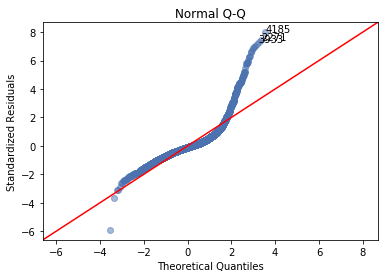

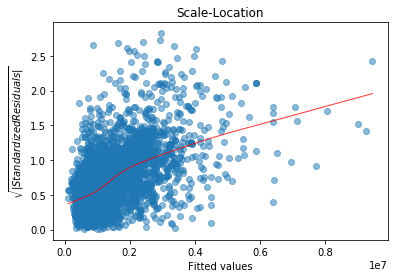

In [948]:
#  Diagnostic model for 0

diagnostic_plots.diagnostic_plots(x_train_norm, y_train2, fit0)

KeyError: 4185

ValueError: Image size of 2983710x7216859 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 432x288 with 1 Axes>

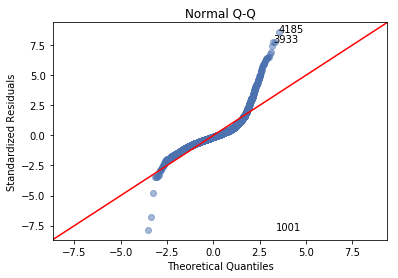

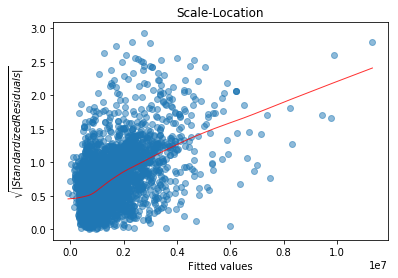

In [949]:
#  Diagnostic model for 1

diagnostic_plots.diagnostic_plots(x_train_norm, y_train2, fit1)

In [ ]:
#  Diagnostic model for 2

diagnostic_plots.diagnostic_plots(x_train_norm, y_train2, fit2)

KeyError: 4185

ValueError: Image size of 2934735x7265631 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 432x288 with 1 Axes>

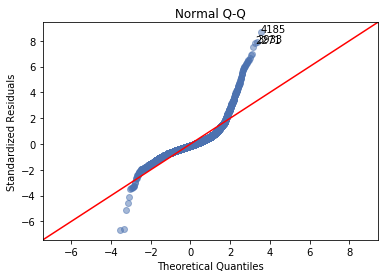

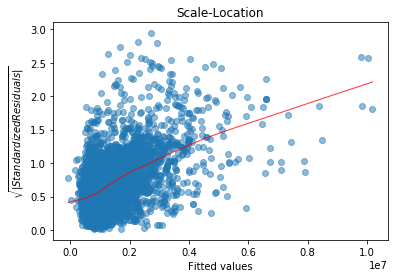

In [946]:
#  Diagnostic model for 3

diagnostic_plots.diagnostic_plots(x_train_norm, y_train2, fit3)

In [ ]:
#  Diagnostic model for 4

diagnostic_plots.diagnostic_plots(x_train_norm, y_train2, fit4)

In [ ]:
#  Diagnostic model for 5

diagnostic_plots.diagnostic_plots(x_train_norm, y_train2, fit5)

In [ ]:
#  Diagnostic model for 6

diagnostic_plots.diagnostic_plots(x_train_norm, y_train2, fit6)

In [ ]:
#  Diagnostic model for 7

diagnostic_plots.diagnostic_plots(x_train_norm, y_train2, fit7)

In [ ]:
#  Diagnostic model for 8

diagnostic_plots.diagnostic_plots(x_train_norm, y_train2, fit8)

In [ ]:
#  Diagnostic model for 9

diagnostic_plots.diagnostic_plots(x_train_norm, y_train2, fit9)

In [ ]:
#  Diagnostic model for 10

diagnostic_plots.diagnostic_plots(x_train_norm, y_train2, fit10)

In [ ]:
#  Diagnostic model for 11

diagnostic_plots.diagnostic_plots(x_train_norm, y_train2, fit11)

In [ ]:
#  Diagnostic model for 12

diagnostic_plots.diagnostic_plots(x_train_norm, y_train2, fit12)

## Learning Curve

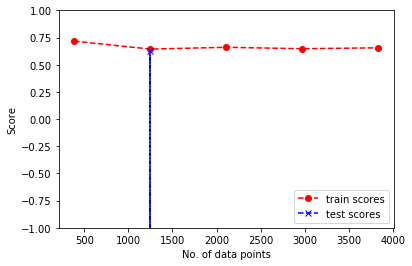

In [957]:
from sklearn.model_selection import learning_curve

model1 = LinearRegression()
model1_fit = model1.fit(x_train_norm, y_train2)

train_sizes, train_scores, test_scores = learning_curve(model1, x_train_norm, y_train2, cv= 4)

ave_train_scores = train_scores.mean(axis=1)
ave_test_scores = test_scores.mean(axis=1)

learn_df = pd.DataFrame({
    'train_size': train_sizes,
    'train_score': ave_train_scores,
    'test_score': ave_test_scores
})

plt.plot(learn_df['train_size'], learn_df['train_score'], 'r--o', label='train scores')
plt.plot(learn_df['train_size'], learn_df['test_score'], 'b--x', label='test scores')
plt.xlabel('No. of data points')
plt.ylabel('Score')
plt.legend(loc='lower right')
plt.ylim(-1,1);

## Exploring other models for comparison

In [ ]:
# The ones that were hashed out were causing errors!

from sklearn import linear_model,ensemble, tree, model_selection, datasets

models = {}
parameters = {}

models['linear_model'] = linear_model.LinearRegression()
models['ridge_model'] = linear_model.Ridge()
models['lasso_model'] = linear_model.Lasso(alpha=.5)
# models['robust_regression'] = linear_model.SGDRegressor(loss='huber',max_iter=2000)
# models['eps_insensitive'] = linear_model.SGDRegressor(loss='epsilon_insensitive',max_iter=2000)


# models['cart'] = tree.DecisionTreeRegressor(max_depth=7)
# models['extratrees'] = tree.ExtraTreeRegressor(max_depth=7)
models['randomForest'] = ensemble.RandomForestRegressor()
models['adaboostedTrees'] = ensemble.AdaBoostRegressor()
models['gradboostedTrees'] = ensemble.GradientBoostingRegressor()


for name,model in models.items():
    scores = model_selection.cross_val_score(model, x_train_norm, y_train2, n_jobs=1)
    print('Model: '+name)
    print("Score: " + str(np.mean(scores)))
    print()

## Takeaway

In [ ]:
#  My OLS model didn't have great training accuracy (r^2 around 0.65), but it generalized decently well.
#  Other models had better training accuracy, but the amount of overfitting was much higher